In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import gudhi as gd
from open3d import io, visualization
from open3d import geometry, utility
import networkx as nx
import random
import numpy as np
import open3d as o3d
import math
import numpy as np
import sklearn
import kmapper as km
import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [54]:

def random_color_generator():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)


def split_cloud(bag, t):
    
    filename = f"persistence_threshold_points\{bag}-{t}.txt"
    
    # if os.path.isfile(filename) and not visualize: return

    # Path
    pathToData = os.path.join(os.getcwd(), 'data', 'bags', bag)

    # Read Data
    pointCloud = io.read_point_cloud(os.path.join(pathToData, 'cloud_final.ply')) # Read point cloud
    pointCloudArray = np.asarray(pointCloud.points)

    if not os.path.isfile(filename):

        # # Create alpha complex
        alphaComplex = gd.AlphaComplex(points = pointCloudArray)

        # # Create simplex tree object
        simplexTree = alphaComplex.create_simplex_tree()
        simplexTree.prune_above_filtration(t)

        points = []

        # Compute adjacency list from skeleton.
        for sk_value in simplexTree.get_skeleton(1):
            i = sk_value[0][0]
            while len(points) != i+1:
                points.append([])
            if sk_value[1] == 0: continue

            v = sk_value[0][1]

            points[i].append(v)

        # Add unidirectional edges
        for i in range(len(points)-1, 0, -1):
            for j in points[i]:
                points[j].append(i)
            points[i].insert(0, i)

        
        # Save adjacencylist to file

        # with open(filename,'r+') as file:
        #     file.truncate(0)

        f = open(filename, "a") 
        for p in points:
            for d in p:
                f.write(f"{d} ")
            f.write("\n")
        f.close()


    # Compute disconnected components
    graph = nx.read_adjlist(filename, nodetype=int)
    subgraphs = nx.connected_components(graph)

    # Retrieve all points from original cloud
    segments = []

    for sg in subgraphs:

        segmentedCloud = [pointCloudArray[i] for i in sg]
        segments.append(segmentedCloud)

    return segments

def visualize_clouds(clouds, colors = [], lines = []):

    vis = []
    for i, c in enumerate(clouds):
        pcd = o3d.geometry.PointCloud()
        
        if len(lines) > i and lines[i] == True:
            pcd = o3d.geometry.LineSet()
            l = [[i,i+1] for i in range(len(c)-1)]
            l.append([len(c)-1, 0])
            pcd.lines = o3d.utility.Vector2iVector(l)

        pcd.points = o3d.utility.Vector3dVector(c)

        color = random_color_generator()
        if len(colors) > i:
            color = colors[i]
        pcd.paint_uniform_color(color)

        vis.append(pcd)
    
    visualization.draw_geometries(vis)
    

c = split_cloud("bag_0", 0.0001)
# split_cloud("bag_1", 0.0001)
# split_cloud("bag_2", 0.0001)
# split_cloud("bag_3", 0.0001)
# split_cloud("bag_4", 0.0001)
# split_cloud("bag_5", 0.0001)

# visualize_clouds(c)


In [59]:



def find_main_tree(clouds):

    totalpoints = np.sum([len(c) for c in clouds])
    minpoints = totalpoints / 4  # TODO: select magic number

    minclouds = [c for c in clouds if len(c) > minpoints]

    # visualize_clouds(minclouds)

    return minclouds[0]    


# c = split_cloud("bag_0", 0.0001)

t = find_main_tree(c)



In [ ]:

# def map_tree(tree):
    
#     data = np.array(tree)

#     mapper = km.KeplerMapper(verbose=2)

#     lens = mapper.fit_transform(data)

#     graph = mapper.map(
#         lens,
#         data,
#         clusterer=sklearn.cluster.DBSCAN(eps=0.1, min_samples=5),
#         cover=km.Cover(n_cubes=15, perc_overlap=0.2),
#     )

#     mapper.visualize(graph, path_html="output/cat.html")

#     km.draw_matplotlib(graph)

#     plt.show()

# map_tree(t)

In [7]:
import math


def find_critical_points(tree, r):
    alphaComplex = gd.AlphaComplex(points = tree)

    # # Create simplex tree object
    simplexTree = alphaComplex.create_simplex_tree()
    simplexTree.prune_above_filtration(r)

    points = []

    # Compute adjacency list from skeleton.
    for sk_value in simplexTree.get_skeleton(1):
        i = sk_value[0][0]
        while len(points) != i+1:
            points.append([])
        if sk_value[1] == 0: continue

        v = sk_value[0][1]

        points[i].append(v)

    # Add unidirectional edges
    for i in range(len(points)-1, 0, -1):
        for j in points[i]:
            points[j].append(i)

    # distances = []
    # for i, a in enumerate(points):
    #     d = []
    #     for p in a:
    #         d.append(math.dist(tree[i], tree[p]))
    #     distances.append(d)

    # print(distances[0])

    mins = []
    maxs = []
    saddles = []

    zindex = 1

    for i, a in enumerate(points):
        if len(a) == 0: continue
        mi = min([tree[d] for d in a], key = lambda t: t[zindex])
        ma = max([tree[d] for d in a], key = lambda t: t[zindex])
        if tree[i][zindex] <= mi[zindex]: mins.append(i)
        if tree[i][zindex] >= ma[zindex]: maxs.append(i)
    
    print(mins)
    print(maxs)

    visualize_clouds(
        [[tree[d] for d in mins], [tree[d] for d in maxs], tree],
        [(1, 0, 0), (0, 1, 0), (1, 1, 0)]
    )

find_critical_points(t, 0.001)

NameError: name 't' is not defined

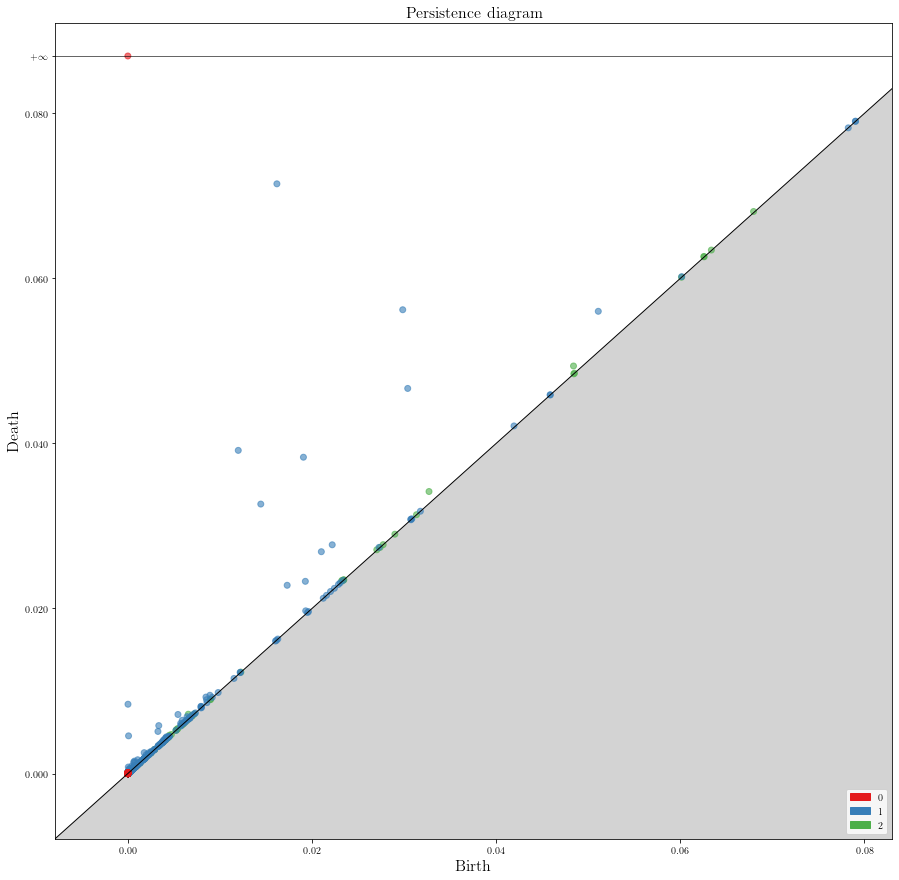

In [60]:

# pathToData = os.path.join(os.getcwd(), 'data', 'bags', "bag_0")

# # Read Data
# pointCloud = io.read_point_cloud(os.path.join(pathToData, 'cloud_final.ply')) # Read point cloud
# pointCloudArray = np.asarray(pointCloud.points)


alphaComplex = gd.AlphaComplex(points = t)

simplexTree = alphaComplex.create_simplex_tree()
persistenceDiagram = simplexTree.persistence()

gd.plot_persistence_diagram(persistenceDiagram, legend=True)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 15)
plt.show()

# print(simplexTree.persistent_betti_numbers(0.06, 0.05))

# print(persistenceDiagram)


In [61]:
cycles = 30
dimension = 2
index = 1

# t = pointCloudArray

# distances = [(p[1], abs(p[1][0]-p[1][1])) for p in persistenceDiagram if p[0] == dimension and not math.isinf(p[1][1]) and p[1][0] < 0.1]
distances = [(p[1], abs(p[1][0]-p[1][1]) / math.sqrt(2)) for p in persistenceDiagram if p[0] == dimension and not math.isinf(p[1][1])]
maxdistances = sorted(distances, key = lambda t: t[1])

print(maxdistances[-cycles:])

# furthestCycle = maxdistances[-index][0]
# print(furthestCycle)


paths = []

for f in maxdistances[-cycles:]: 

    furthestCycle = f[0]

    connectionPoints = None

    for splx in simplexTree.get_filtration() :
        if splx[1] == 0: continue
        # print(splx)
        if splx[1] != furthestCycle[1]: continue 
        connectionPoints = splx[0]
        print(splx)


    # c = simplexTree.copy() 
    # c.prune_above_filtration(furthestCycle[0])

    # points = []

    # # Compute adjacency list from skeleton.
    # for sk_value in c.get_skeleton(2):
    #     i = sk_value[0][0]
    #     while len(points) != i+1:
    #         points.append([])
    #     if sk_value[1] == 0: continue

    #     if len(sk_value[0]) != 3: continue

    #     # print(sk_value)
    #     points[i].append(sk_value[0][1])
    #     points[i].append(sk_value[0][2])


    # # Add unidirectional edges
    # for i in range(len(points)-1, 0, -1):
    #     for j in points[i]:
    #         points[j].append(i)
    #     points[i].insert(0, i)


    # filename = "points.txt"

    # with open(filename,'r+') as file:
    #     file.truncate(0)

    # f = open(filename, "a") 
    # for p in points:
    #     for d in p:
    #         f.write(f"{d} ")
    #     f.write("\n")
    # f.close()


    print(connectionPoints)


    path = connectionPoints

    # graph = nx.read_adjlist(filename, nodetype=int)
    # for i, p in enumerate(connectionPoints):      
    #     j = (i+1) % len(connectionPoints)  
    #     if nx.has_path(graph, p, connectionPoints[j]):
    #         path = path + nx.shortest_path(graph, p, connectionPoints[j])


    print(path)

    paths.append([t[d] for d in path])

paths.append(t)

# visualize_clouds(
#     paths,
#     [
#         (0, 0, 1),
#         (1, 1, 0)
#     ],
#     lines=[True]
# )

[((4.586894510964818e-05, 7.608261723795215e-05), 2.1364292446470724e-05), ((0.00015600904485221925, 0.00018651428058610845), 2.157045904912724e-05), ((5.5385472681264e-05, 8.702152005730677e-05), 2.2370063629538722e-05), ((0.0005313931218488023, 0.0005631686350067399), 2.2468680829659992e-05), ((0.0005492192554846118, 0.0005824077115007243), 2.346778230610464e-05), ((6.664711540842483e-05, 9.994823090640005e-05), 2.354744458969471e-05), ((0.00010264893269077975, 0.00013704739773272556), 2.4323387893568276e-05), ((7.348647697752247e-05, 0.00010820511672508923), 2.4549785599077258e-05), ((7.789946558777613e-05, 0.00011276076898031853), 2.4650664029868326e-05), ((0.0005506220586738544, 0.0005855748827479038), 2.4715378924380764e-05), ((0.00025868778536599816, 0.00029409372801137736), 2.5035782138849597e-05), ((9.055124963738732e-05, 0.00012676761175107727), 2.560883524049773e-05), ((7.830319822354367e-05, 0.00011584634360280845), 2.6547012684750523e-05), ((0.0002510421053427791, 0.000290

In [62]:

colors = [(0, 0, 1) for i in range(len(paths)-1)]
colors.append((1, 1, 0))

visualize_clouds(
    paths,
    colors,
    lines=[True for i in range(len(paths)-1)]
)

In [12]:
lastConnected = None
for i, p in enumerate(persistenceDiagram):
    if p[0] == 0 and not math.isinf(p[1][1]):
        lastConnected = p
        break

print(lastConnected)


# for splx in simplexTree.get_filtration() :
#     if splx[1] == 0: continue
#     if splx[1] != furthestCycle[1]: continue 
#     connectionPoints = splx[0]
#     print(splx)


c = simplexTree.copy() 
c.prune_above_filtration(lastConnected[1][1])
c.compute_persistence()

print(c.betti_numbers())



(0, (0.0, 9.816324541579905e-05))
[1, 155, 42]


In [69]:
from pc_skeletor import LBC

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(t)

lbc = LBC(point_cloud=pcd, down_sample=0.008)
lbc.extract_skeleton()
lbc.extract_topology()
lbc.visualize()
lbc.show_graph(lbc.skeleton_graph)
lbc.show_graph(lbc.topology_graph)
lbc.save('./output')
lbc.animate(init_rot=np.asarray([[1, 0, 0], [0, 0, 1], [0, 1, 0]]),
            steps=300,
            output='./output')

2023-06-22 15:41:18,135 - PCD #points: 35526
Current volume ratio 0.10254354089321915. Contraction weights 1024.349856321794. Attraction weights 102.09337950494954. Progress LBC:  20%|██        | 4/20 [00:11<00:44,  2.81s/it]2023-06-22 15:41:33,972 - Contraction is Done.


Contraction is Done.


Current volume ratio 0.10254354089321915. Contraction weights 1024.349856321794. Attraction weights 102.09337950494954. Progress LBC:  20%|██        | 4/20 [00:14<00:56,  3.51s/it]
C:\Users\spier\AppData\Local\Programs\Python\Python310\lib\site-packages\mistree\mst\branches.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  branch_index.append(np.ndarray.tolist(np.ndarray.flatten(np.array(_twig))))
C:\Users\spier\AppData\Local\Programs\Python\Python310\lib\site-packages\mistree\mst\branches.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bran

KeyboardInterrupt: 